In [1]:
import requests
import pandas as pd
from IPython.display import display
import json

def market_fiyat_api(arama_terimi, lat=39.97041, lng=32.85647, distance=5000):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Accept-Encoding': 'gzip, deflate',
        'Origin': 'https://marketfiyati.org.tr',
        'Referer': 'https://marketfiyati.org.tr/',
        'Cache-Control': 'no-cache',
        'Pragma': 'no-cache',
        'Connection': 'keep-alive'
    }
    
    try:
        # Nearest API isteği
        nearest_url = 'https://api.marketfiyati.org.tr/api/v2/nearest'
        nearest_data = {
            'latitude': str(lat),
            'longitude': str(lng),
            'distance': distance
        }
        
        requests.packages.urllib3.disable_warnings()
        
        nearest_response = requests.post(
            nearest_url,
            json=nearest_data,
            headers=headers,
            verify=False
        )
        
        nearest_markets = nearest_response.json()
        depots = [market['id'] for market in nearest_markets]
        
        # Search API isteği
        search_url = 'https://api.marketfiyati.org.tr/api/v2/search'
        search_data = {
            'keywords': arama_terimi,
            'pages': 0,
            'size': 100,
            'depots': depots,
            'latitude': str(lat),
            'longitude': str(lng),
            'distance': distance
        }
        
        search_response = requests.post(
            search_url,
            json=search_data,
            headers=headers,
            verify=False
        )
        
        results = search_response.json()
        
        # Verileri düzenle
        rows = []
        for item in results['content']:
            for depot_info in item['productDepotInfoList']:
                row = {
                    'name': item['title'],
                    'brand': item.get('brand', ''),
                    'marketName': depot_info['marketAdi'],
                    'depotName': depot_info['depotName'],
                    'price': depot_info['price'],
                    'updateDate': depot_info['indexTime'],
                    'marketDistance': depot_info.get('distance', 0)
                }
                rows.append(row)
        
        df = pd.DataFrame(rows)
        
        if not df.empty:
            # Tarihi düzenle
            df['updateDate'] = pd.to_datetime(df['updateDate'], format='%d.%m.%Y %H:%M')
            df['updateDate'] = df['updateDate'].dt.strftime('%Y-%m-%d %H:%M')
            
            # Fiyatları düzenle
            df['price'] = pd.to_numeric(df['price'], errors='coerce')
            
            # Mesafeyi düzenle
            if 'marketDistance' in df.columns:
                df['marketDistance'] = df['marketDistance'].round(2)
                df = df.rename(columns={'marketDistance': 'mesafe_km'})
            
            # Sıralama
            df = df.sort_values('price')
            
            return df
            
        return pd.DataFrame()
        
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")
        return pd.DataFrame()



In [9]:
ilce_df = pd.read_csv('ilce.csv',index_col=0)
ilce_df

,il_plaka,ilce_id,ilce_adi,lat,lon,northeast_lat,northeast_lon,southwest_lat,southwest_lon,İl
0,1,1,ALADAĞ(KARSANTI),37.546379,35.402962,37.555225,35.418969,37.537532,35.386955,Adana
1,1,2,CEYHAN,37.031700,35.822750,37.055723,35.850071,37.006241,35.795967,Adana
2,1,3,ÇUKUROVA,37.000000,35.321333,37.072004,35.461995,36.935523,35.174706,Adana
3,1,4,FEKE,37.819918,35.912484,37.824131,35.922007,37.811669,35.903793,Adana
4,1,5,İMAMOĞLU,37.258751,35.672840,37.272539,35.675316,37.245506,35.646995,Adana
...,...,...,...,...,...,...,...,...,...,...
952,81,953,DÜZCE,40.843849,31.156540,40.891762,31.195807,40.824717,31.106662,Düzce
953,81,954,GÖLYAKA,40.776579,30.995727,40.783131,31.008601,40.770669,30.989599,Düzce
954,81,955,GÜMÜŞOVA,40.850000,30.933333,40.853631,30.949511,40.841169,30.930489,Düzce
955,81,956,KAYNAŞLI,40.777337,31.303267,40.781931,31.314301,40.769469,31.295299,Düzce


In [10]:
il_df = pd.read_csv('il.csv')
ilce_df = pd.read_csv('ilce.csv')

# İl merkezlerini al
il_merkezleri = il_df[['plaka', 'il_adi', 'lat', 'lon']].copy()
il_merkezleri = il_merkezleri.rename(columns={
    'plaka': 'il_plaka',
    'il_adi': 'ilce_adi',
    'lon': 'lng'
})

# Her ilden 2 ilçe seç
secili_ilceler = []
import numpy as np
np.random.seed(42)  # Tekrarlanabilirlik için

for il_plaka in sorted(ilce_df['il_plaka'].unique()):
    # İl merkezi olmayan ilçeleri al
    il_ilceler = ilce_df[
        (ilce_df['il_plaka'] == il_plaka) & 
        (ilce_df['ilce_adi'] != ilce_df['İl'])  # İl merkezi olmayanlar
    ].copy()
    
    if len(il_ilceler) >= 2:
        # 2 ilçe seç
        secilen = il_ilceler.sample(n=2, random_state=42)
        secili_ilceler.append(secilen[['il_plaka', 'ilce_adi', 'lat', 'lon', 'İl']].rename(columns={'lon': 'lng', 'İl': 'il_adi'}))
    elif len(il_ilceler) == 1:
        # Sadece 1 ilçe varsa onu seç
        secili_ilceler.append(il_ilceler[['il_plaka', 'ilce_adi', 'lat', 'lon', 'İl']].rename(columns={'lon': 'lng', 'İl': 'il_adi'}))

# İl merkezleri ve seçili ilçeleri birleştir
secili_merkezler = pd.concat([il_merkezleri] + secili_ilceler, ignore_index=True)

# İstatistikler
print("\nSeçilen Merkez İstatistikleri:")
print(f"Toplam il merkezi sayısı: {len(il_merkezleri)}")
print(f"Toplam ilçe sayısı: {len(secili_merkezler) - len(il_merkezleri)}")
print(f"Toplam merkez sayısı: {len(secili_merkezler)}")

# İl bazında dağılımı kontrol et
il_dagilimi = secili_merkezler.groupby('il_plaka').size()
print("\nİl başına düşen merkez sayısı:")
print(il_dagilimi.value_counts().sort_index())

# Her il için seçilen merkezleri göster
print("\nİl bazında seçilen merkezler:")
for il_plaka in sorted(secili_merkezler['il_plaka'].unique()):
    il_merkezler = secili_merkezler[secili_merkezler['il_plaka'] == il_plaka]
    il_adi = il_merkezler['il_adi'].iloc[0] if 'il_adi' in il_merkezler.columns else il_merkezler['ilce_adi'].iloc[0]
    print(f"\nİl: {il_adi} (Plaka: {il_plaka})")
    print(f"Seçilen merkezler: {', '.join(il_merkezler['ilce_adi'].tolist())}")
    


Seçilen Merkez İstatistikleri:
Toplam il merkezi sayısı: 81
Toplam ilçe sayısı: 162
Toplam merkez sayısı: 243

İl başına düşen merkez sayısı:
3    81
Name: count, dtype: int64

İl bazında seçilen merkezler:

İl: nan (Plaka: 1)
Seçilen merkezler: ADANA, SAİMBEYLİ, SEYHAN

İl: nan (Plaka: 2)
Seçilen merkezler: ADIYAMAN, SİNCİK, BESNİ

İl: nan (Plaka: 3)
Seçilen merkezler: AFYONKARAHİSAR, AFYON, BAŞMAKÇI

İl: nan (Plaka: 4)
Seçilen merkezler: AĞRI, DİYADİN, PATNOS

İl: nan (Plaka: 5)
Seçilen merkezler: AMASYA, AMASYA, GÖYNÜCEK

İl: nan (Plaka: 6)
Seçilen merkezler: ANKARA, ELMADAĞ, KEÇİÖREN

İl: nan (Plaka: 7)
Seçilen merkezler: ANTALYA, AKSEKİ, ELMALI

İl: nan (Plaka: 8)
Seçilen merkezler: ARTVİN, ARHAVİ, MURGUL(GÖKTAŞ)

İl: nan (Plaka: 9)
Seçilen merkezler: AYDIN, AYDIN, BOZDOĞAN

İl: nan (Plaka: 10)
Seçilen merkezler: BALIKESİR, AYVALIK, BURHANİYE

İl: nan (Plaka: 11)
Seçilen merkezler: BİLECİK, BOZÜYÜK, PAZARYERİ

İl: nan (Plaka: 12)
Seçilen merkezler: BİNGÖL, BİNGÖL, SOLHAN

İl: nan

In [7]:
domates_df=pd.DataFrame()
for i in range(len(secili_merkezler)):
    a=market_fiyat_api("domates",lat=secili_merkezler["lat"].iloc[i],lng=secili_merkezler["lng"].iloc[i])
    a["taranan_merkez"]=secili_merkezler["ilce_adi"].iloc[i]
    a["taranan_lat"]=secili_merkezler["lat"].iloc[i]
    a["taranan_lng"]=secili_merkezler["lng"].iloc[i]
    a["il_plaka"]=secili_merkezler["il_plaka"].iloc[i]
    ilce=secili_merkezler["ilce_adi"].iloc[i]
    domates_df=pd.concat([domates_df,a],axis=0)
    print(f"{ilce} çekildi")

ADANA çekildi
ADIYAMAN çekildi
AFYONKARAHİSAR çekildi
AĞRI çekildi
AMASYA çekildi
ANKARA çekildi
ANTALYA çekildi
ARTVİN çekildi
AYDIN çekildi
BALIKESİR çekildi
BİLECİK çekildi
BİNGÖL çekildi
BİTLİS çekildi
BOLU çekildi
BURDUR çekildi
BURSA çekildi
ÇANAKKALE çekildi
ÇANKIRI çekildi
ÇORUM çekildi
DENİZLİ çekildi
DİYARBAKIR çekildi
EDİRNE çekildi
ELAZIĞ çekildi
ERZİNCAN çekildi
ERZURUM çekildi
ESKİŞEHİR çekildi
GAZİANTEP çekildi
GİRESUN çekildi
GÜMÜŞHANE çekildi
HAKKARİ çekildi
HATAY çekildi
ISPARTA çekildi
MERSİN(İÇEL) çekildi
İSTANBUL çekildi
İZMİR çekildi
KARS çekildi
KASTAMONU çekildi
KAYSERİ çekildi
KIRKLARELİ çekildi
KIRŞEHİR çekildi
KOCAELİ çekildi
KONYA çekildi
KÜTAHYA çekildi
MALATYA çekildi
MANİSA çekildi
KAHRAMANMARAŞ çekildi
MARDİN çekildi
MUĞLA çekildi
MUŞ çekildi
NEVŞEHİR çekildi
NİĞDE çekildi
ORDU çekildi
RİZE çekildi
SAKARYA çekildi
SAMSUN çekildi
SİİRT çekildi
SİNOP çekildi
SİVAS çekildi
TEKİRDAĞ çekildi
TOKAT çekildi
TRABZON çekildi
TUNCELİ çekildi
ŞANLIURFA çekildi
UŞAK

In [21]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def create_choropleth_map(df, shp_path):
    """
    Türkiye il sınırları üzerinde fiyat dağılımını gösteren ısı haritası (matplotlib ile)
    """
    # Shapefile'ı yükle
    turkey_geo = gpd.read_file(shp_path)
    
    # İl bazlı medyan fiyatları hesapla
    il_fiyatlari = df.groupby("il_plaka")["price"].mean()
    
    # GeoDataFrame'e fiyatları ekle
    turkey_geo['fiyat'] = turkey_geo['plaka'].map(il_fiyatlari)
    
    # Plot oluştur
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Türkiye haritasını çiz
    turkey_geo.boundary.plot(ax=ax, linewidth=1, color="black")
    
    # Fiyatlar ile il sınırlarını doldur
    norm = Normalize(vmin=il_fiyatlari.min(), vmax=il_fiyatlari.max())
    sm = ScalarMappable(cmap="YlOrRd", norm=norm)
    turkey_geo.plot(column='fiyat', ax=ax, legend=True, cmap="YlOrRd", 
                    legend_kwds={'label': "Dana Kıyma Fiyatı (TL)", 'orientation': "horizontal"})
    
    # Başlık ve etiketler
    ax.set_title("İl Bazlı Dana Kıyma Ortalama Fiyatı Dağılımı", fontsize=16)


    # Grafik etrafındaki beyaz boşlukları kaldırmak için
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Haritayı PNG olarak kaydet
    plt.savefig('domates_fiyat_haritasi_matplotlib.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()

    print("Harita 'domates_fiyat_haritasi_matplotlib.png' olarak kaydedildi.")

# Shapefile yolu
shp_path = "C:/Users/Bora/Documents/GitHub/web-tufe/updated_turkey_geo.shp"  # shapefile'ınızın tam yolunu belirtin

# Haritayı oluştur
create_choropleth_map(domates_df, shp_path)

# İstatistikleri göster
il_fiyatlari = domates_df.groupby("il_plaka")["price"].median()
print("\nFiyat İstatistikleri:")
print(f"En düşük il ortalaması: {il_fiyatlari.min():.2f} TL")
print(f"En yüksek il ortalaması: {il_fiyatlari.max():.2f} TL")
print(f"Türkiye ortalaması: {il_fiyatlari.mean():.2f} TL")

# En ucuz ve en pahalı 5 il
print("\nEn Ucuz 5 İl:")
print(il_fiyatlari.sort_values().head())
print("\nEn Pahalı 5 İl:")
print(il_fiyatlari.sort_values().tail())


Harita 'domates_fiyat_haritasi_matplotlib.png' olarak kaydedildi.

Fiyat İstatistikleri:
En düşük il ortalaması: 37.00 TL
En yüksek il ortalaması: 45.90 TL
Türkiye ortalaması: 42.76 TL

En Ucuz 5 İl:
il_plaka
79    37.000
27    37.000
75    39.900
69    39.900
46    39.925
Name: price, dtype: float64

En Pahalı 5 İl:
il_plaka
6     45.9
34    45.9
26    45.9
47    45.9
40    45.9
Name: price, dtype: float64


In [17]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


turkey_geo = gpd.read_file(shp_path)



# Create a GeoDataFrame for il_df with lat and lon
il_df['geometry'] = il_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
il_gdf = gpd.GeoDataFrame(il_df, geometry='geometry', crs=turkey_geo.crs)

# Ensure CRS consistency
il_gdf = il_gdf.set_crs(turkey_geo.crs, allow_override=True)

# Perform spatial join with proximity-based matching using 'dwithin'
joined = gpd.sjoin(turkey_geo, il_gdf, how="left", predicate='dwithin', distance=0.01)

# Drop duplicates to avoid multiple plaka values for the same polygon
joined = joined.drop_duplicates(subset=['geometry'])

# Check the result to ensure proper matching
print(joined[['plaka', 'geometry']].head())

# Update the 'plaka' in turkey_geo with the joined 'plaka' from il_df
turkey_geo['plaka'] = joined['plaka']

# Save the updated shapefile if needed
turkey_geo.to_file("updated_turkey_geo.shp")


   plaka                                           geometry
0      1  MULTIPOLYGON (((35.41434 36.5882, 35.41347 36....
1      2  POLYGON ((38.1033 37.9024, 38.11007 37.90416, ...
2      3  POLYGON ((30.19456 37.87817, 30.20171 37.86722...
3      4  POLYGON ((43.10198 39.32246, 43.0951 39.32087,...
4     68  POLYGON ((33.24951 38.26498, 33.26122 38.27609...


In [ ]:
domates_df=pd.DataFrame()
for i in range(len(secili_merkezler)):
    a=market_fiyat_api("domates",lat=secili_merkezler["lat"].iloc[i],lng=secili_merkezler["lng"].iloc[i])
    a["taranan_merkez"]=secili_merkezler["ilce_adi"].iloc[i]
    a["taranan_lat"]=secili_merkezler["lat"].iloc[i]
    a["taranan_lng"]=secili_merkezler["lng"].iloc[i]
    a["il_plaka"]=secili_merkezler["il_plaka"].iloc[i]
    ilce=secili_merkezler["ilce_adi"].iloc[i]
    domates_df=pd.concat([domates_df,a],axis=0)
    print(f"{ilce} çekildi")

In [32]:
pd.read_csv("ağırlıklar.csv")["Ürün"].to_csv("maddeler.csv")

In [4]:
sepet=pd.read_csv("sepet.csv").iloc[:,[0,1]]
sepet.columns=["Madde","Ürün"]
sepet.to_csv("eskisepet.csv")

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split

# BERT Tokenizer'ı yükleyelim
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Veriyi BERT'e uygun hale getirelim
eskisepet_new_df = sepet[['Ürün', 'Madde']]

# Ürün isimlerini tokenize edelim
def tokenize_function(examples):
    return tokenizer(examples['Ürün'], padding="max_length", truncation=True, max_length=64)

# DataFrame'i Dataset formatına dönüştürme
dataset = Dataset.from_pandas(eskisepet_new_df)

# Tokenize işlemi
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Etiketleri sayısal verilere dönüştürme
label2id = {label: i for i, label in enumerate(eskisepet_new_df['Madde'].unique())}

# Madde etiketini doğru şekilde almak için güncelleme
# Madde etiketini doğru şekilde almak için güncelleme
tokenized_datasets = tokenized_datasets.map(
    lambda x: {'labels': [label2id[label] for label in x['Madde']]}, 
    batched=True
)



# Eğitim ve test verilerini ayıralım
train_dataset, test_dataset = tokenized_datasets.train_test_split(test_size=0.2).values()

# Modeli yükleyelim (BERT)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(eskisepet_new_df['Madde'].unique()))

# Eğitim argümanlarını belirleyelim
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Trainer'ı oluşturup eğitelim
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Modeli eğitelim
trainer.train()


In [ ]:
# BERT modelini kaydedelim
model.save_pretrained('./bert_model')
tokenizer.save_pretrained('./bert_model')


In [6]:
iller=["İSTANBUL","EDİRNE","BALIKESİR","İZMİR","DENİZLİ","MANİSA","BURSA","KOCAELİ","ANKARA","KONYA","ANTALYA","ADANA","HATAY","NEVŞEHİR","KAYSERİ","ZONGULDAK","KASTAMONU","SAMSUN","TRABZON",
       "ERZURUM","KARS","MALATYA","VAN","GAZİANTEP","DİYARBAKIR","SİİRT"]

Eşleşen il sayısı: 81 / 81


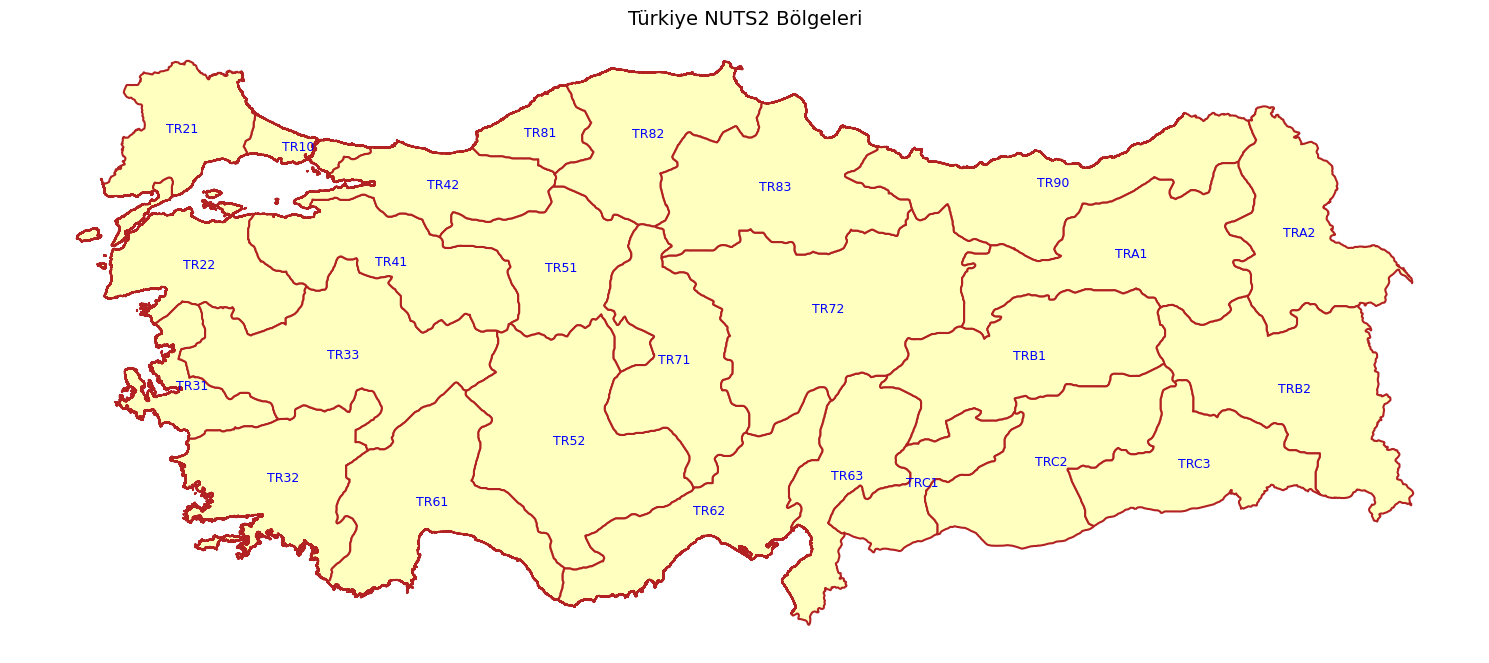

In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# İl shapefile dosyasını yükle
turkey_provinces = gpd.read_file('C:/Users/Bora/Documents/GitHub/web-tufe/updated_turkey_geo.shp')

# NAME_1 sütununu kullan (il adı için)
province_name_col = 'NAME_1'
#['Bartın', 'Bingöl', 'Çanakkale', 'Çankiri', 'Çorum', 'Düzce', 'Elazığ', 'Gümüshane', 'Iğdır', 'K. Maras', 'Karabük', 'Kinkkale', 'Kütahya']

# NUTS2 bölgelerine göre il eşleştirme tablosu (shapefile'daki yazım şekline göre)
nuts2_mapping = {
    'TR10': ['Istanbul'],
    'TR21': ['Tekirdag', 'Edirne', 'Kirklareli'],
    'TR22': ['Balikesir', 'Çanakkale'],
    'TR31': ['Izmir'],
    'TR32': ['Aydin', 'Denizli', 'Mugla'],
    'TR33': ['Manisa', 'Afyon', 'Kütahya', 'Usak'],
    'TR41': ['Bursa', 'Eskisehir', 'Bilecik'],
    'TR42': ['Kocaeli', 'Sakarya', 'Düzce', 'Bolu', 'Yalova'],
    'TR51': ['Ankara'],
    'TR52': ['Konya', 'Karaman'],
    'TR61': ['Antalya', 'Isparta', 'Burdur'],
    'TR62': ['Adana', 'Mersin'],
    'TR63': ['Hatay', 'K. Maras', 'Osmaniye'],
    'TR71': ['Kinkkale', 'Aksaray', 'Nigde', 'Nevsehir', 'Kirsehir'],
    'TR72': ['Kayseri', 'Sivas', 'Yozgat'],
    'TR81': ['Zinguldak', 'Karabük', 'Bartın'],
    'TR82': ['Kastamonu', 'Çankiri', 'Sinop'],
    'TR83': ['Samsun', 'Tokat', 'Çorum', 'Amasya'],
    'TR90': ['Trabzon', 'Ordu', 'Giresun', 'Rize', 'Artvin', 'Gümüshane'],
    'TRA1': ['Erzurum', 'Erzincan', 'Bayburt'],
    'TRA2': ['Agri', 'Kars', 'Iğdır', 'Ardahan'],
    'TRB1': ['Malatya', 'Elazığ', 'Bingöl', 'Tunceli'],
    'TRB2': ['Van', 'Mus', 'Bitlis', 'Hakkari'],
    'TRC1': ['Gaziantep', 'Adiyaman', 'Kilis'],
    'TRC2': ['Sanliurfa', 'Diyarbakir'],
    'TRC3': ['Mardin', 'Batman', 'Sirnak', 'Siirt']
}

# Her il için NUTS2 bölgesini belirle
def get_nuts2_for_province(province_name):
    if not isinstance(province_name, str):
        return None
    
    # NAME_1 sütununda tam eşleşme ara
    for nuts2_code, provinces in nuts2_mapping.items():
        if province_name in provinces:
            return nuts2_code
    
    # Alternatif: ID_1 sütununa dayalı doğrudan eşleştirme
    # Bu kısmı kodun hemen sonrasında vereceğim
    
    return None

# İl adı sütununa göre NUTS2 kodlarını ekle
turkey_provinces['NUTS2_CODE'] = turkey_provinces[province_name_col].apply(get_nuts2_for_province)

# Eşleşme durumunu kontrol et
matched_count = turkey_provinces['NUTS2_CODE'].notna().sum()
print(f"Eşleşen il sayısı: {matched_count} / {len(turkey_provinces)}")

# NUTS2 bölgelerine göre illeri birleştir
nuts2_regions = turkey_provinces.dissolve(by='NUTS2_CODE')

# Haritayı çiz
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# NUTS2 bölgelerini çiz
nuts2_regions.plot(ax=ax, facecolor='#FFFFC0', edgecolor='#B22222', linewidth=1.5)

# NUTS2 kodlarını haritaya ekle
for idx, row in nuts2_regions.iterrows():
    if pd.notna(idx):  # None değil ise
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        plt.text(x, y, idx, fontsize=9, ha='center', va='center', color='blue')

# Harita başlığını ekle
plt.title('Türkiye NUTS2 Bölgeleri', fontsize=14)

# Arka plan rengini ayarla (deniz için)
ax.set_facecolor('#D6EAF8')

# Eksenleri kaldır
plt.axis('off')

# Haritayı kaydet
plt.tight_layout()
plt.savefig('turkiye_nuts2_bolgeler.png', dpi=300, bbox_inches='tight')
plt.show()

# NUTS2 shapefile'ı olarak kaydet
nuts2_regions.reset_index().to_file('turkey_nuts2.shp')

#['Bartın', 'Bingöl', 'Çanakkale', 'Çankiri', 'Çorum', 'Düzce', 'Elazığ', 'Gümüshane', 'Iğdır', 'K. Maras', 'Karabük', 'Kinkkale', 'Kütahya']


In [96]:
madde=pd.read_excel("Weights_2022.xlsx")
madde=madde.iloc[4:137,[1]]

In [27]:
market_fiyat_api("pirinç",lat=il_df[il_df["il_adi"]==i]["lat"],lng=il_df[il_df["il_adi"]==i]["lon"])

Hata oluştu: string indices must be integers


""


In [99]:
market_fiyat_api("Sosis")

""


In [38]:
df=pd.DataFrame()
import time
for i in (iller):
    for ürün in madde["Unnamed: 1"].values:
        a=market_fiyat_api(f"{ürün}",lat=il_df[il_df["il_adi"]==i]["lat"].values[0],lng=il_df[il_df["il_adi"]==i]["lon"].values[0])
        time.sleep(1)

        a["İL"]=il_df[il_df["il_adi"]==i]["il_adi"].values[0]
        df=pd.concat([df,a],axis=0)
        print(f"{i} {ürün} çekildi")

İSTANBUL Pirinç çekildi
İSTANBUL Buğday Unu çekildi
İSTANBUL Bebek Sütü  çekildi
İSTANBUL Bulgur çekildi
İSTANBUL Ekmek çekildi
İSTANBUL Bisküvi çekildi
İSTANBUL Kraker çekildi
İSTANBUL Gofret çekildi
İSTANBUL Pasta çekildi
İSTANBUL Kek çekildi
İSTANBUL Baklava çekildi
İSTANBUL Yufka çekildi
İSTANBUL Makarna çekildi
İSTANBUL Şehriye çekildi
İSTANBUL Tahıl Gevreği çekildi
İSTANBUL kıyma çekildi
İSTANBUL Kuzu çekildi
İSTANBUL Tavuk çekildi
İSTANBUL Sakatat çekildi
İSTANBUL Sucuk çekildi
İSTANBUL Sosis çekildi
İSTANBUL Salam çekildi
İSTANBUL Hazır Et Yemekleri çekildi
İSTANBUL Balık çekildi
İSTANBUL Konserve Balık çekildi
İSTANBUL Süt çekildi
İSTANBUL Yoğurt çekildi
İSTANBUL Hazır Sütlü Tatlılar çekildi
İSTANBUL Beyaz Peynir çekildi
İSTANBUL Kaşar Peyniri çekildi
İSTANBUL Tulum Peyniri çekildi
İSTANBUL Krem Peynir çekildi
İSTANBUL Yumurta çekildi
İSTANBUL Tereyağı (Kahvaltılık) çekildi
İSTANBUL Margarin çekildi
İSTANBUL Zeytinyağı çekildi
İSTANBUL Ayçiçek Yağı çekildi
İSTANBUL Portakal çe

In [2]:
sepet=pd.read_csv("sepet.csv")
sepet=sepet.rename(columns={"Unnamed: 0":"Madde"})

In [5]:
df=pd.read_csv("marketler.csv",index_col=0)

In [62]:
unq_df=df[["name"]].drop_duplicates()

In [63]:
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizer
import torch


product_names = unq_df["name"].tolist()  # 'name' sütununu alıyoruz

# Modeli ve tokenizer'ı yükleyelim
model = BertForSequenceClassification.from_pretrained('D:/model/bert_model')
tokenizer = BertTokenizer.from_pretrained('D:/model/bert_tokenizer')

# Ürün adlarını tokenize edelim
inputs = tokenizer(product_names, padding=True, truncation=True, return_tensors="pt", max_length=64)

# Modeli değerlendirme moduna alalım
model.eval()

# Tahmin yapalım
with torch.no_grad():  # Gradients'i kaydetmeye gerek yok
    outputs = model(**inputs)

# Çıktıyı alalım (logits)
logits = outputs.logits

# Logitleri softmax ile olasılıklara dönüştürelim
probs = torch.nn.functional.softmax(logits, dim=-1)

# Tahmin edilen etiketlerin ID'lerini bulalım
predictions = torch.argmax(probs, dim=-1)

# Eğer eğitim veri setinde madde etiketlerini öğrenmek istiyorsanız:
# Madde gruplarını çıkaralım (etiketlerin sırasıyla)
id2label = {i: label for i, label in enumerate(sepet["Unnamed: 0"].unique())}  # Dummy ID2Label mapping
predicted_labels = [id2label[pred.item()] for pred in predictions]






In [ ]:
unq_df["predicted_label"]=predicted_labels

unq_df=unq_df.set_index("name")

In [69]:
df=df.set_index("name")
df["predicted_label"]=unq_df["predicted_label"]

In [72]:
df=df.reset_index()

In [100]:
df[df["predicted_label"]=="Kabak"]

,name,brand,marketName,depotName,2025-02-28,updateDate,mesafe_km,İL,predicted_label
439,Bey Tavuk baget,Beypılıç,carrefour,Istanbul Cıhangır Gurme,122.90,2025-02-28 07:23,0.0,İSTANBUL,Kabak
927,Düzceden Portakal Kurusu 50 Gr,Düzceden,tarim_kredi,Istanbul Fatih Market,50.00,2025-02-28 07:23,0.0,İSTANBUL,Kabak
932,Portakal Finike Gurme,Markasız,carrefour,Istanbul Cıhangır Gurme,55.90,2025-02-28 07:23,0.0,İSTANBUL,Kabak
975,Armut Deveci,Markasız,a101,Atlamataşı Fatih Istanbul,39.50,2025-02-28 07:22,0.0,İSTANBUL,Kabak
978,Armut Deveci,Markasız,bim,Marmarayfatih,44.50,2025-02-28 07:22,0.0,İSTANBUL,Kabak
...,...,...,...,...,...,...,...,...,...
74778,Sarımsak,Markasız,bim,Bahçelievler Merkez Siirt,235.00,2025-02-28 07:23,0.0,SİİRT,Kabak
74779,Sarımsak Kuru,Sarımsak Kuru Kg,carrefour,Rıze Merkez Süper,236.90,2025-02-28 07:23,0.0,SİİRT,Kabak
75300,Kabak Sakız Ekonomik,Markasız,migros,Bitlis M Migros,32.95,2025-02-28 07:23,0.0,SİİRT,Kabak
75303,Kabak Sakız,Markasız,migros,Mjet Siirt Hastane,39.95,2025-02-28 07:23,0.0,SİİRT,Kabak
